# Weight and Nutrition Analysis

This notebook analyzes weight measurements and nutrition data, showing average weekly weight and average weekly calories.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Date range for analysis
# START_CUTOFF_DATE: Only include data on or after this date (required)
START_CUTOFF_DATE = '2025-10-09'
# END_CUTOFF_DATE: Only include data on or before this date (None = include all)
END_CUTOFF_DATE = None

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')

## Discover and Copy Latest Data

In [2]:
import os
import glob
import shutil
from pathlib import Path

# Find the latest File-Export folder in Downloads
downloads_dir = Path.home() / 'Downloads'
export_pattern = str(downloads_dir / 'File-Export-*')
export_folders = glob.glob(export_pattern)

# Filter to only directories and sort by modification time (most recent first)
export_folders = [f for f in export_folders if os.path.isdir(f)]
export_folders.sort(key=os.path.getmtime, reverse=True)

if not export_folders:
    raise FileNotFoundError("No File-Export folders found in Downloads")

latest_export = Path(export_folders[0])
export_name = latest_export.name

print(f"Latest data export found: {export_name}")
print(f"Full path: {latest_export}")

# List files in the export folder
export_files = list(latest_export.glob('*.csv'))
print(f"\nFiles in export:")
for f in export_files:
    print(f"  - {f.name}")

Latest data export found: File-Export-2025-10-10-to-2026-01-27
Full path: /Users/peter.wills@equipmentshare.com/Downloads/File-Export-2025-10-10-to-2026-01-27

Files in export:
  - Measurement-Summary-2025-10-10-to-2026-01-27.csv
  - Exercise-Summary-2025-10-10-to-2026-01-27.csv
  - Nutrition-Summary-2025-10-10-to-2026-01-27.csv


In [3]:
# Copy the export folder to the data directory
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

target_dir = data_dir / export_name

# Remove existing target directory if it exists
if target_dir.exists():
    shutil.rmtree(target_dir)
    print(f"Removed existing directory: {target_dir}")

# Copy the entire export folder
shutil.copytree(latest_export, target_dir)
print(f"\nCopied data to: {target_dir}")

# Find the measurement and nutrition files
measurement_files = list(target_dir.glob('Measurement-Summary-*.csv'))
nutrition_files = list(target_dir.glob('Nutrition-Summary-*.csv'))

if not measurement_files or not nutrition_files:
    raise FileNotFoundError("Could not find Measurement or Nutrition summary files")

measurement_file = measurement_files[0]
nutrition_file = nutrition_files[0]

print(f"\nUsing files:")
print(f"  Weight: {measurement_file.name}")
print(f"  Nutrition: {nutrition_file.name}")


Copied data to: data/File-Export-2025-10-10-to-2026-01-27

Using files:
  Weight: Measurement-Summary-2025-10-10-to-2026-01-27.csv
  Nutrition: Nutrition-Summary-2025-10-10-to-2026-01-27.csv


## Load Data

In [4]:
# Load weight data
weight_df = pd.read_csv(measurement_file)
weight_df['Date'] = pd.to_datetime(weight_df['Date'])

# Load nutrition data
nutrition_df = pd.read_csv(nutrition_file)
nutrition_df['Date'] = pd.to_datetime(nutrition_df['Date'])

print(f"Weight data shape: {weight_df.shape}")
print(f"Nutrition data shape: {nutrition_df.shape}")

Weight data shape: (87, 2)
Nutrition data shape: (416, 20)


In [5]:
# Filter data based on date range
start_date = pd.to_datetime(START_CUTOFF_DATE)
weight_df = weight_df[weight_df['Date'] >= start_date]
nutrition_df = nutrition_df[nutrition_df['Date'] >= start_date]

if END_CUTOFF_DATE is not None:
    end_date = pd.to_datetime(END_CUTOFF_DATE)
    weight_df = weight_df[weight_df['Date'] <= end_date]
    nutrition_df = nutrition_df[nutrition_df['Date'] <= end_date]

# Check daily calorie totals to identify the high intake days
daily_totals = nutrition_df.groupby('Date')['Calories'].sum().reset_index()
daily_totals['DayOfWeek'] = daily_totals['Date'].dt.day_name()
print("Top 10 highest calorie days:")
print(daily_totals.sort_values('Calories', ascending=False).head(10))

# Remove bike trip days (Friday Oct 17, Saturday Oct 18, Sunday Oct 19, 2025)
# These were extremely high intake days that will skew energy expenditure calculations
bike_trip_dates = pd.to_datetime(['2025-10-17', '2025-10-18', '2025-10-19'])
nutrition_df = nutrition_df[~nutrition_df['Date'].isin(bike_trip_dates)]

print(f"\n--- After filtering ---")
print(f"Filtered weight data shape: {weight_df.shape}")
print(f"Filtered nutrition data shape: {nutrition_df.shape}")
print(f"\nDate range: {weight_df['Date'].min()} to {weight_df['Date'].max()}")

Top 10 highest calorie days:
         Date  Calories  DayOfWeek
8  2025-10-18    7476.7   Saturday
7  2025-10-17    5996.8     Friday
71 2025-12-25    5064.2   Thursday
77 2025-12-31    5044.3  Wednesday
70 2025-12-24    4247.1  Wednesday
9  2025-10-19    4160.4     Sunday
1  2025-10-11    4141.8   Saturday
76 2025-12-30    4081.2    Tuesday
48 2025-11-27    3924.4   Thursday
16 2025-10-26    3876.1     Sunday

--- After filtering ---
Filtered weight data shape: (87, 2)
Filtered nutrition data shape: (404, 20)

Date range: 2025-10-10 00:00:00 to 2026-01-24 00:00:00


## Calculate Weekly Averages

In [6]:
# Add week column (weeks run Monday to Sunday, so use W-SUN which ends on Sunday)
weight_df['Week'] = weight_df['Date'].dt.to_period('W-SUN')
nutrition_df['Week'] = nutrition_df['Date'].dt.to_period('W-SUN')

# Calculate average weekly weight
weekly_weight = weight_df.groupby('Week')['Weight'].mean().reset_index()
weekly_weight['Week_Start'] = weekly_weight['Week'].dt.start_time

# Calculate total daily calories, then average by week
daily_calories = nutrition_df.groupby('Date')['Calories'].sum().reset_index()

# ONE-TIME HACK (change calories for a day in progress)
daily_calories.loc[daily_calories['Date'] == '2025-12-07', 'Calories'] = 2600

daily_calories['Week'] = daily_calories['Date'].dt.to_period('W-SUN')
weekly_calories = daily_calories.groupby('Week')['Calories'].mean().reset_index()
weekly_calories['Week_Start'] = weekly_calories['Week'].dt.start_time

# Calculate implied energy expenditure
# For each week, we use:
# - Average daily calories consumed in that week
# - Weight change from previous week to current week
# - Formula: Energy Expenditure = Calories Consumed - (Weight Change * 3500 / 7)
weekly_data = weekly_weight.merge(weekly_calories, on=['Week', 'Week_Start'], how='inner')
weekly_data['Weight_Change'] = weekly_data['Weight'].diff()  # Current week - previous week
weekly_data['Daily_Calories_From_Weight_Change'] = -(weekly_data['Weight_Change'] * 3500 / 7)
weekly_data['Implied_Energy_Expenditure'] = weekly_data['Calories'] + weekly_data['Daily_Calories_From_Weight_Change']

# print("Weekly Weight Summary:")
# print(weekly_weight)
# print("\nWeekly Calories Summary:")
# print(weekly_calories)
# print("\nWeekly Data with Implied Energy Expenditure:")
# print(weekly_data[['Week_Start', 'Weight', 'Weight_Change', 'Calories', 'Implied_Energy_Expenditure']])

In [7]:
# Debug chart: Data points per week
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Count weight measurements per week
weight_counts = weight_df.groupby('Week').size().reset_index(name='Count')
weight_counts['Week_Start'] = weight_counts['Week'].dt.start_time

# Count nutrition days per week (unique dates with calorie data)
nutrition_counts = daily_calories.groupby('Week').size().reset_index(name='Count')
nutrition_counts['Week_Start'] = nutrition_counts['Week'].dt.start_time

# # Plot weight data points
# ax1.bar(weight_counts['Week_Start'], weight_counts['Count'], color='#2E86AB', alpha=0.7)
# ax1.set_xlabel('Week Starting (Monday)', fontsize=11)
# ax1.set_ylabel('Number of Measurements', fontsize=11)
# ax1.set_title('Weight Measurements per Week', fontsize=12, fontweight='bold')
# ax1.tick_params(axis='x', rotation=45)
# ax1.axhline(y=7, color='red', linestyle='--', alpha=0.5, label='Full week (7 days)')
# ax1.legend()

# # Add value labels
# for i, row in weight_counts.iterrows():
#     ax1.annotate(f"{row['Count']}", 
#                 xy=(row['Week_Start'], row['Count']),
#                 xytext=(0, 5), textcoords='offset points',
#                 ha='center', fontsize=10)

# # Plot nutrition data points
# ax2.bar(nutrition_counts['Week_Start'], nutrition_counts['Count'], color='#A23B72', alpha=0.7)
# ax2.set_xlabel('Week Starting (Monday)', fontsize=11)
# ax2.set_ylabel('Number of Days', fontsize=11)
# ax2.set_title('Nutrition Log Days per Week', fontsize=12, fontweight='bold')
# ax2.tick_params(axis='x', rotation=45)
# ax2.axhline(y=7, color='red', linestyle='--', alpha=0.5, label='Full week (7 days)')
# ax2.legend()

# # Add value labels
# for i, row in nutrition_counts.iterrows():
#     ax2.annotate(f"{row['Count']}", 
#                 xy=(row['Week_Start'], row['Count']),
#                 xytext=(0, 5), textcoords='offset points',
#                 ha='center', fontsize=10)

# plt.suptitle('Data Points per Week (Debug)', fontsize=14, fontweight='bold', y=1.02)
# plt.tight_layout()
# plt.show()

# Print detailed breakdown
print("\nDetailed week breakdown:")
print("=" * 60)
for week in weight_counts['Week'].unique():
    week_start = week.start_time
    week_end = week.end_time
    weight_n = weight_counts[weight_counts['Week'] == week]['Count'].values[0]
    nutrition_n = nutrition_counts[nutrition_counts['Week'] == week]['Count'].values[0] if week in nutrition_counts['Week'].values else 0
    print(f"{week_start.strftime('%Y-%m-%d')} (Mon) to {week_end.strftime('%Y-%m-%d')} (Sun): "
          f"Weight={weight_n}, Nutrition={nutrition_n}")


Detailed week breakdown:
2025-10-06 (Mon) to 2025-10-12 (Sun): Weight=3, Nutrition=3
2025-10-13 (Mon) to 2025-10-19 (Sun): Weight=5, Nutrition=4
2025-10-20 (Mon) to 2025-10-26 (Sun): Weight=7, Nutrition=7
2025-10-27 (Mon) to 2025-11-02 (Sun): Weight=7, Nutrition=7
2025-11-03 (Mon) to 2025-11-09 (Sun): Weight=5, Nutrition=7
2025-11-10 (Mon) to 2025-11-16 (Sun): Weight=7, Nutrition=7
2025-11-17 (Mon) to 2025-11-23 (Sun): Weight=7, Nutrition=7
2025-11-24 (Mon) to 2025-11-30 (Sun): Weight=6, Nutrition=7
2025-12-01 (Mon) to 2025-12-07 (Sun): Weight=7, Nutrition=7
2025-12-08 (Mon) to 2025-12-14 (Sun): Weight=5, Nutrition=7
2025-12-15 (Mon) to 2025-12-21 (Sun): Weight=3, Nutrition=4
2025-12-22 (Mon) to 2025-12-28 (Sun): Weight=3, Nutrition=5
2025-12-29 (Mon) to 2026-01-04 (Sun): Weight=6, Nutrition=7
2026-01-05 (Mon) to 2026-01-11 (Sun): Weight=5, Nutrition=7
2026-01-12 (Mon) to 2026-01-18 (Sun): Weight=5, Nutrition=7
2026-01-19 (Mon) to 2026-01-25 (Sun): Weight=6, Nutrition=7


In [8]:
weekly_weight

,Week,Weight,Week_Start
0,2025-10-06/2025-10-12,180.266667,2025-10-06
1,2025-10-13/2025-10-19,179.480000,2025-10-13
2,2025-10-20/2025-10-26,181.228571,2025-10-20
3,2025-10-27/2025-11-02,179.271429,2025-10-27
4,2025-11-03/2025-11-09,178.680000,2025-11-03
5,2025-11-10/2025-11-16,176.900000,2025-11-10
6,2025-11-17/2025-11-23,176.914286,2025-11-17
7,2025-11-24/2025-11-30,176.483333,2025-11-24
8,2025-12-01/2025-12-07,176.042857,2025-12-01
9,2025-12-08/2025-12-14,176.520000,2025-12-08


<Axes: xlabel='Week_Start'>

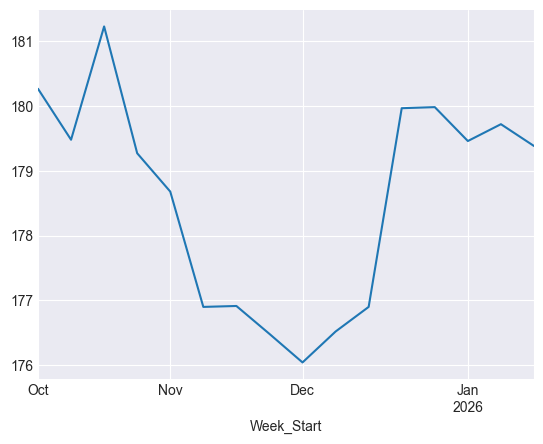

In [9]:
weekly_weight.set_index("Week_Start")['Weight'].plot()

## Visualizations

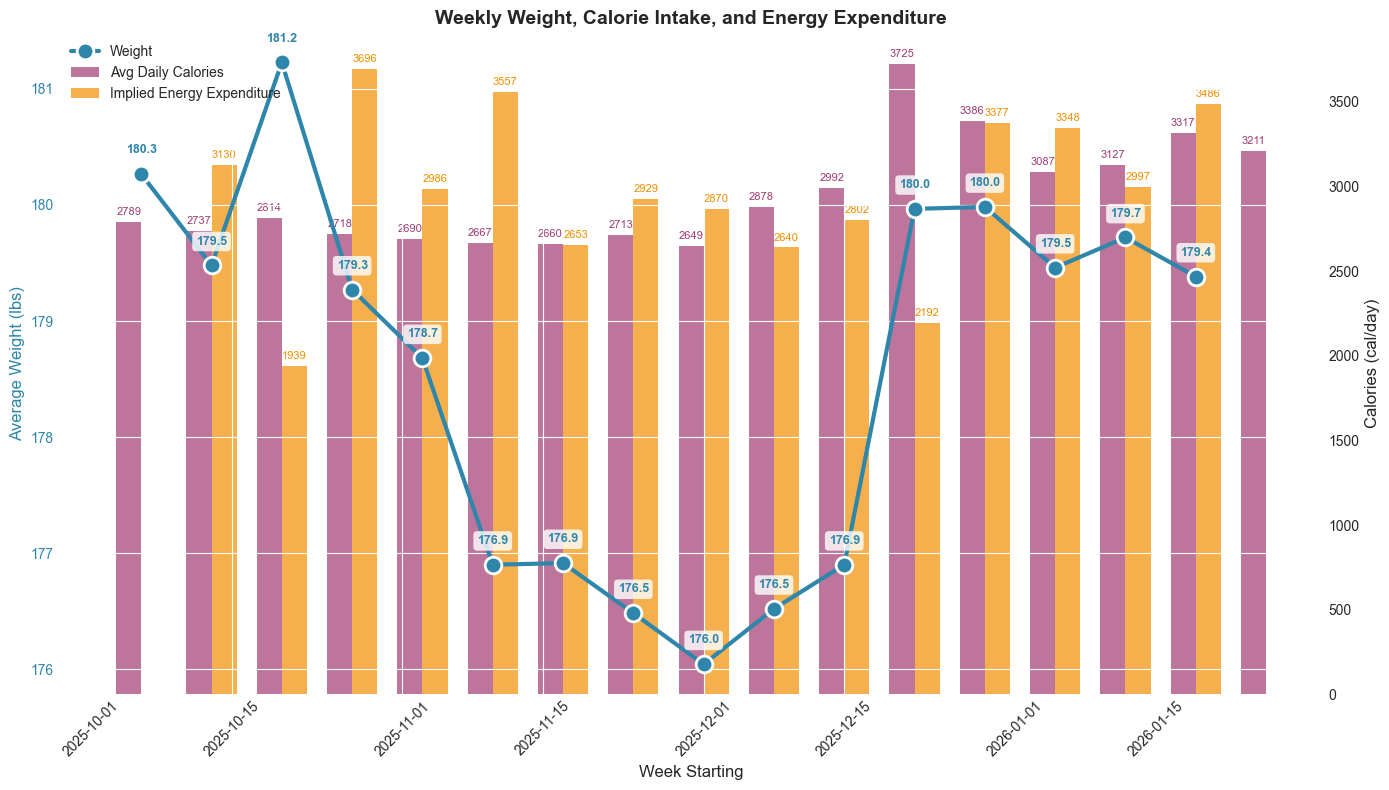

In [10]:
# Create a single figure with dual y-axes
fig, ax1 = plt.subplots(1, 1, figsize=(14, 8))

# Left y-axis setup first
color_weight = '#2E86AB'
ax1.set_xlabel('Week Starting', fontsize=12)
ax1.set_ylabel('Average Weight (lbs)', fontsize=12, color=color_weight)
ax1.tick_params(axis='y', labelcolor=color_weight)
ax1.tick_params(axis='x', rotation=45)

# Right y-axis: Calories and Energy Expenditure (bar plots)
ax2 = ax1.twinx()
ax2.set_ylabel('Calories (cal/day)', fontsize=12)

# Add grid to ax2 so it stays visible
ax2.grid(True, alpha=0.3)

# Prepare data for bar plots
x = weekly_calories['Week_Start']
width = pd.Timedelta(days=2.5)  # Width of bars

# Plot calories bars
color_calories = '#A23B72'
ax2.bar(x - width/2, weekly_calories['Calories'], width=width, 
        label='Avg Daily Calories', color=color_calories, alpha=0.7)

# Plot energy expenditure bars (skip first week)
weekly_data_plot = weekly_data[weekly_data['Implied_Energy_Expenditure'].notna()]
color_expenditure = '#F18F01'
ax2.bar(weekly_data_plot['Week_Start'] + width/2, weekly_data_plot['Implied_Energy_Expenditure'], 
        width=width, label='Implied Energy Expenditure', color=color_expenditure, alpha=0.7)

# Add value labels on bars
for i, row in weekly_calories.iterrows():
    ax2.annotate(f"{row['Calories']:.0f}", 
                xy=(row['Week_Start'] - width/2, row['Calories']),
                xytext=(0, 5), textcoords='offset points',
                ha='center', fontsize=8, color=color_calories)

for i, row in weekly_data_plot.iterrows():
    ax2.annotate(f"{row['Implied_Energy_Expenditure']:.0f}", 
                xy=(row['Week_Start'] + width/2, row['Implied_Energy_Expenditure']),
                xytext=(0, 5), textcoords='offset points',
                ha='center', fontsize=8, color=color_expenditure)

# Plot weight line on ax1
ax1.plot(weekly_weight['Week_Start'], weekly_weight['Weight'], 
         marker='o', linewidth=3, markersize=12, color=color_weight, 
         markeredgecolor='white', markeredgewidth=2, label='Weight')

# Add value labels on weight points with background
for i, row in weekly_weight.iterrows():
    # Add white background box for better visibility
    ax1.annotate(f"{row['Weight']:.1f}", 
                xy=(row['Week_Start'], row['Weight']),
                xytext=(0, 15), textcoords='offset points',
                ha='center', fontsize=9, color=color_weight, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.8))

# Set z-order for axes to bring weight line to front
ax1.set_zorder(ax2.get_zorder() + 1)
ax1.patch.set_visible(False)  # Hide ax1 background so ax2 is visible

# Add title and legends
ax1.set_title('Weekly Weight, Calorie Intake, and Energy Expenditure', fontsize=14, fontweight='bold')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

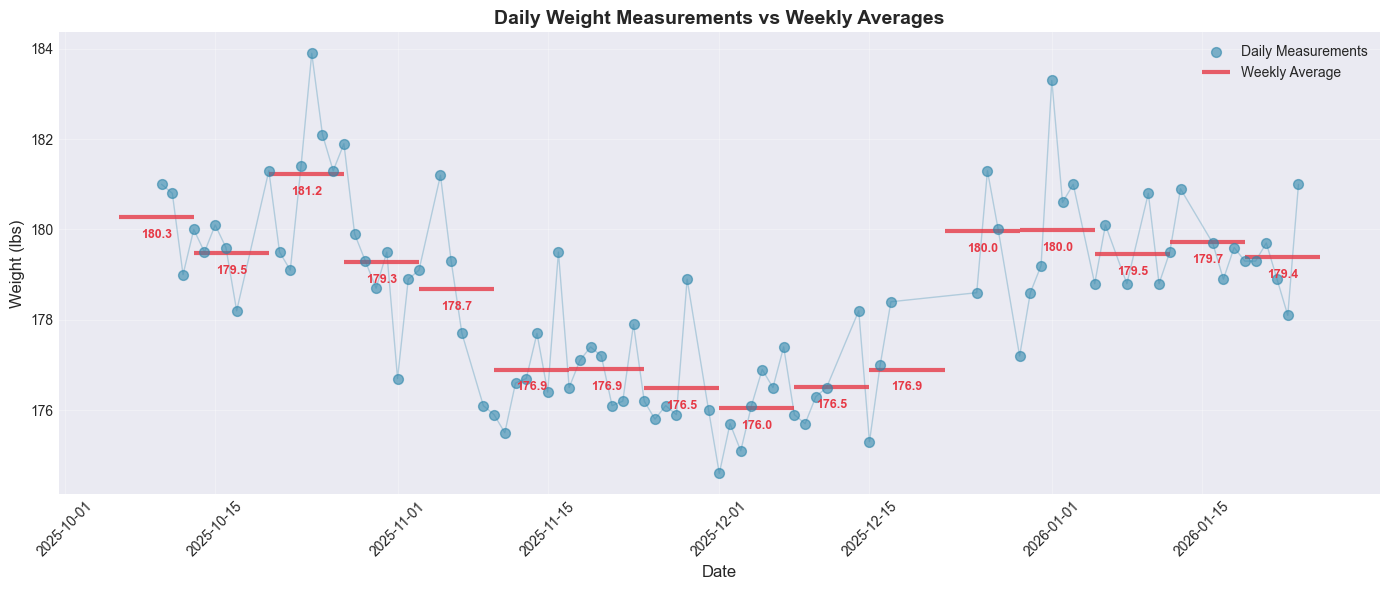

In [11]:
# Daily weight values vs weekly average
fig, ax = plt.subplots(figsize=(14, 6))

# Plot daily weight measurements as scatter points
ax.scatter(weight_df['Date'], weight_df['Weight'], 
           color='#2E86AB', alpha=0.6, s=50, label='Daily Measurements', zorder=3)

# Plot weekly average as a step function spanning each week
for _, row in weekly_weight.iterrows():
    week_start = row['Week'].start_time
    week_end = row['Week'].end_time
    ax.hlines(y=row['Weight'], xmin=week_start, xmax=week_end, 
              color='#E63946', linewidth=3, alpha=0.8, zorder=2)
    # Add weekly average label at the midpoint
    mid_date = week_start + (week_end - week_start) / 2
    ax.annotate(f"{row['Weight']:.1f}", 
                xy=(mid_date, row['Weight']),
                xytext=(0, -15), textcoords='offset points',
                ha='center', fontsize=9, color='#E63946', fontweight='bold')

# Add a line connecting daily points for trend visibility
ax.plot(weight_df['Date'], weight_df['Weight'], 
        color='#2E86AB', alpha=0.3, linewidth=1, zorder=1)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Weight (lbs)', fontsize=12)
ax.set_title('Daily Weight Measurements vs Weekly Averages', fontsize=14, fontweight='bold')
ax.legend(['Daily Measurements', 'Weekly Average'], loc='upper right')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

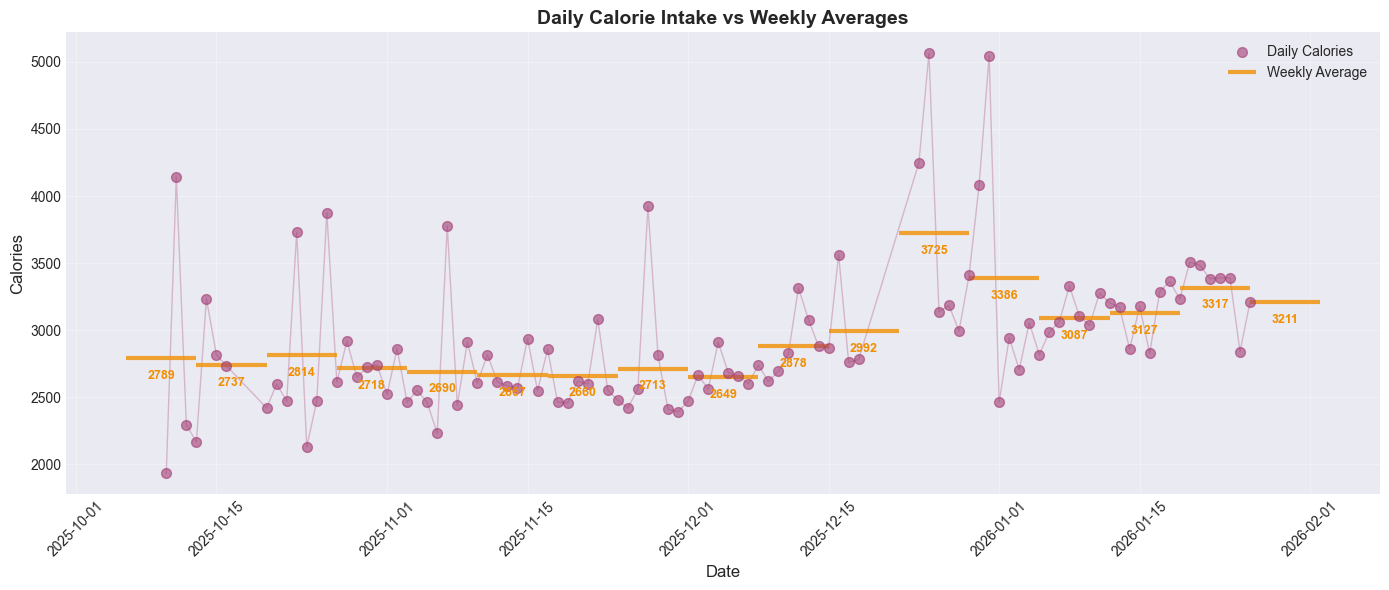

In [12]:
# Daily calories vs weekly average
fig, ax = plt.subplots(figsize=(14, 6))

# Plot daily calorie values as scatter points
ax.scatter(daily_calories['Date'], daily_calories['Calories'], 
           color='#A23B72', alpha=0.6, s=50, label='Daily Calories', zorder=3)

# Plot weekly average as a step function spanning each week
for _, row in weekly_calories.iterrows():
    week_start = row['Week'].start_time
    week_end = row['Week'].end_time
    ax.hlines(y=row['Calories'], xmin=week_start, xmax=week_end, 
              color='#F18F01', linewidth=3, alpha=0.8, zorder=2)
    # Add weekly average label at the midpoint
    mid_date = week_start + (week_end - week_start) / 2
    ax.annotate(f"{row['Calories']:.0f}", 
                xy=(mid_date, row['Calories']),
                xytext=(0, -15), textcoords='offset points',
                ha='center', fontsize=9, color='#F18F01', fontweight='bold')

# Add a line connecting daily points for trend visibility
ax.plot(daily_calories['Date'], daily_calories['Calories'], 
        color='#A23B72', alpha=0.3, linewidth=1, zorder=1)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Calories', fontsize=12)
ax.set_title('Daily Calorie Intake vs Weekly Averages', fontsize=14, fontweight='bold')
ax.legend(['Daily Calories', 'Weekly Average'], loc='upper right')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary Statistics

In [13]:
print("=" * 50)
print("SUMMARY STATISTICS")
print("=" * 50)

print("\nWeight Statistics:")
print(f"  Overall average: {weight_df['Weight'].mean():.1f} lbs")
print(f"  Minimum: {weight_df['Weight'].min():.1f} lbs")
print(f"  Maximum: {weight_df['Weight'].max():.1f} lbs")
print(f"  Change: {weight_df['Weight'].iloc[-1] - weight_df['Weight'].iloc[0]:.1f} lbs")

print("\nCalories Statistics:")
print(f"  Overall daily average: {daily_calories['Calories'].mean():.0f} calories")
print(f"  Minimum daily: {daily_calories['Calories'].min():.0f} calories")
print(f"  Maximum daily: {daily_calories['Calories'].max():.0f} calories")

print("\n" + "=" * 50)
print("ENERGY EXPENDITURE ANALYSIS")
print("=" * 50)
weekly_data_valid = weekly_data[weekly_data['Implied_Energy_Expenditure'].notna()]
if len(weekly_data_valid) > 0:
    avg_expenditure = weekly_data_valid['Implied_Energy_Expenditure'].mean()
    print(f"\n  Average daily expenditure: {avg_expenditure:.0f} calories/day")
    print(f"  Minimum daily expenditure: {weekly_data_valid['Implied_Energy_Expenditure'].min():.0f} calories/day")
    print(f"  Maximum daily expenditure: {weekly_data_valid['Implied_Energy_Expenditure'].max():.0f} calories/day")
    
    avg_intake = daily_calories['Calories'].mean()
    net_balance = avg_intake - avg_expenditure
    print(f"\n  Average calorie intake: {avg_intake:.0f} calories/day")
    print(f"  Net calorie balance: {net_balance:+.0f} calories/day")
    if net_balance < 0:
        print(f"  → You're in a calorie deficit of {abs(net_balance):.0f} calories/day")
    else:
        print(f"  → You're in a calorie surplus of {net_balance:.0f} calories/day")
else:
    print("\n  Not enough data to calculate")

print("\n" + "=" * 50)
print("\nWeekly Trends:")
print(f"  Number of weeks: {len(weekly_weight)}")
print(f"  Average weekly weight range: {weekly_weight['Weight'].min():.1f} - {weekly_weight['Weight'].max():.1f} lbs")
print(f"  Average weekly calories range: {weekly_calories['Calories'].min():.0f} - {weekly_calories['Calories'].max():.0f} calories")

SUMMARY STATISTICS

Weight Statistics:
  Overall average: 178.5 lbs
  Minimum: 174.6 lbs
  Maximum: 183.9 lbs
  Change: 0.0 lbs

Calories Statistics:
  Overall daily average: 2931 calories
  Minimum daily: 1931 calories
  Maximum daily: 5064 calories

ENERGY EXPENDITURE ANALYSIS

  Average daily expenditure: 2973 calories/day
  Minimum daily expenditure: 1939 calories/day
  Maximum daily expenditure: 3696 calories/day

  Average calorie intake: 2931 calories/day
  Net calorie balance: -42 calories/day
  → You're in a calorie deficit of 42 calories/day


Weekly Trends:
  Number of weeks: 16
  Average weekly weight range: 176.0 - 181.2 lbs
  Average weekly calories range: 2649 - 3725 calories
